# 高维线性回归实现
p维样本x，p=200
$$
y=0.05+\sum_{i=1}^{p} 0.01 x_{i}+\epsilon
$$

# 权重衰减
增大数据集可能会减轻过拟合，但是获取更多合适的数据集往往是麻烦的。权重衰减（weight decy）常常用来应对过拟合问题。
## 1. 方法
权重衰减等价于$L_{2}$范数正则化，其通过为模型损失函数添加惩罚项使得learn的参数值较小，是应对过拟合的常用手段。

$$
\ell\left(w_{1}, w_{2}, b\right)=\frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}\left(x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}\right)^{2}
$$

而带有$L_{2}$范数惩罚项的新损失函数为：

$$
\ell\left(w_{1}, w_{2}, b\right)+\frac{\lambda}{2 n}\|\boldsymbol{w}\|^{2}
$$

$\lambda$为超参数，$\boldsymbol{w}=\left\lceil w_{1}, w_{2}\right\rceil$

所以权重的更新算法有所改变：
$$
\begin{array}{l}{w_{1} \leftarrow\left(1-\frac{\eta \lambda}{|\mathcal{B}|}\right) w_{1}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} x_{1}^{(i)}\left(x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}\right)} \\ {w_{2} \leftarrow\left(1-\frac{\eta \lambda}{|\mathcal{B}|}\right) w_{2}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} x_{2}^{(i)}\left(x_{1}^{(i)} w_{1}+x_{2}^{(i)} w_{2}+b-y^{(i)}\right)}\end{array}
$$

要点：使得参数更新时乘上了个小于等于1的系数，所以叫权重衰减。

# 高维线性回归实现
p维样本x，p=200
$$
y=0.05+\sum_{i=1}^{p} 0.01 x_{i}+\epsilon
$$

In [7]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import d2lzh_pytorch as d2l

In [4]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 1. 初始化模型参数
为每个参数附上初值，梯度

In [5]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 2. L2 范数惩罚项

In [6]:
def l2_penalty(w):
    return (w**2).sum() / 2

## 3. 定义训练和测试

In [11]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
dataset = Data.TensorDataset(train_features, train_labels)
train_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

def L2_fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.497069358825684


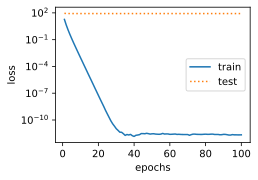

In [12]:
L2_fit_and_plot(lambd=0)

L2 norm of w: 0.04542866721749306


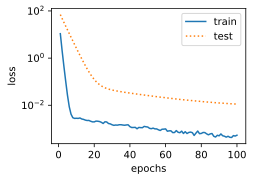

In [13]:
L2_fit_and_plot(lambd=3)

# 简洁实现
可以定义多个optimizer对模型不同参数采用不同的更新方法。

In [16]:
import torch.optim as optim

# 数据集前面已经定义过了
def L2_fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    # 注意加入权重衰减
    optimizer_w = optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    # 不加入
    optimizer_b = optim.SGD(params=[net.bias], lr=lr)
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 12.712525367736816


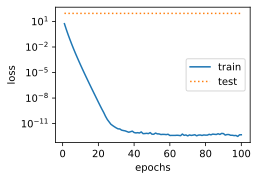

In [17]:
L2_fit_and_plot_pytorch(0)

L2 norm of w: 0.06533976644277573


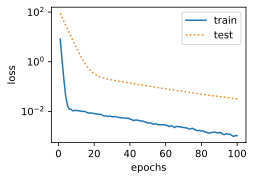

In [18]:
L2_fit_and_plot_pytorch(3)